In [8]:
import glob

# get all the csv files in the DATA/deployments folder
deployments = glob.glob('./DATA/deployments/*_deployments.csv')
deployments
assert len(deployments) == 6

In [23]:
# we want to make three parquet files, one for deployments, one for proposals, and one for votes
# start with deployments

import pandas as pd

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime


def deployments_csv_to_parquet(filenames: iter, out_filename: str) -> None:
    rows_count = 0
    chunksize = 1000000  # this is the number of lines
    t1 = datetime.now()
    table_exists = False
    pqwriter = None
    # if filename exists, raise error
    if glob.glob(out_filename):
        raise FileExistsError(f'{out_filename} already exists')
    for file in filenames:
        for i, df in enumerate(pd.read_csv(file, chunksize=chunksize)):
            print(df.shape)
            # make 'website' and 'additional' columns strings
            df['website'] = df['website'].astype(str)
            df['additional'] = df['additional'].astype(str)
            # set col order
            df = df[['platform', 'platform_id', 'name', 'website', 'additional', 'votes_count', 'proposals_count']]
            table = pa.Table.from_pandas(df)
            # 0 platform: string
            # 1 platform_id: string
            # 2 name: string
            # 3 website: double
            # 4 additional: string
            # 5 votes_count: int64
            # 6 proposals_count: int64
            # cast the fourth column to string
            # if file doesn't exist, create it
            if not table_exists:
                # create a parquet write object giving it an output file
                pqwriter = pq.ParquetWriter(out_filename, table.schema)
                table_exists = True
            pqwriter.write_table(table)
            rows_count += len(df)
            print('.')
    if pqwriter:
        pqwriter.close()
    t2 = datetime.now()
    total = t2 - t1
    print(f'took {total} to pandas concat')
    print(f'wrote {rows_count} rows to {out_filename}')

deployments_csv_to_parquet(deployments, 'parquets/deployments.parquet')


(2165, 7)
.
(2375, 7)
.
(58, 7)
.
(3528, 7)
.
(20782, 7)
.
(2387, 7)
.
took 0:00:00.126763 to pandas concat
wrote 31295 rows to parquets/deployments.parquet


In [37]:
import pyarrow.parquet as pq

with pq.ParquetFile('parquets/deployments.parquet') as pf:
    num_rows = pf.metadata.num_rows
    num_columns = len(pf.metadata.schema.names)
assert num_rows == 31_295
print(num_rows, num_columns)


31295 7


<Axes: >

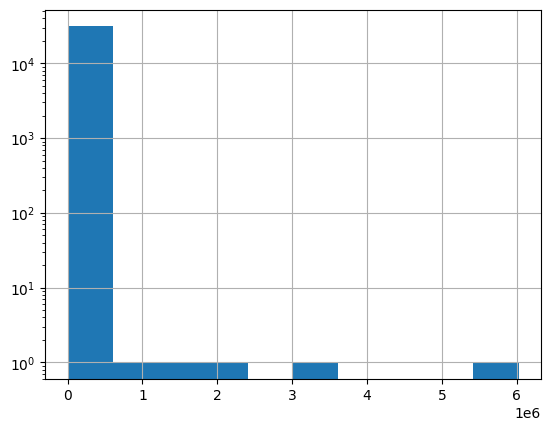

In [28]:
# read parquet file
import pyarrow.parquet as pq

with pq.ParquetFile('parquets/deployments.parquet') as pf:
    df = pf.read().to_pandas()
df.votes_count.hist(log=True)

In [29]:
# now let's do proposals

In [39]:
import glob
from datetime import datetime
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# get all the csv files in the DATA/deployments folder
proposals = glob.glob('./proposals/*/*_proposals.parquet')
assert len(proposals) == 4
proposals

['./proposals/daostack/daostack_proposals.parquet',
 './proposals/snapshot/snapshot_proposals.parquet',
 './proposals/aragon/aragon_proposals.parquet',
 './proposals/daohaus/daohaus_proposals.parquet']

In [43]:

def proposals_csv_to_parquet(filenames: iter, out_filename: str) -> None:
    rows_count = 0
    chunksize = 1000000  # this is the number of lines
    t1 = datetime.now()
    table_exists = False
    pqwriter = None
    # if filename exists, raise error
    if glob.glob(out_filename):
        raise FileExistsError(f'{out_filename} already exists')
    for file in filenames:
        # for i, df in enumerate(pd.read_csv(file, chunksize=chunksize)):
        df = pd.read_parquet(file) 
    
        print("Doing file", file)
        # print(df.info())
        # make author column a string
        df['author'] = df['author'].astype(str)
        table = pa.Table.from_pandas(df)
        # if file doesn't exist, create it
        if not table_exists:
            # create a parquet write object giving it an output file
            pqwriter = pq.ParquetWriter(out_filename, table.schema)
            table_exists = True
        pqwriter.write_table(table)
        rows_count += len(df)
        print('.')
    if pqwriter:
        pqwriter.close()
    t2 = datetime.now()
    total = t2 - t1
    print(f'took {total} to pandas concat')
    print(f'wrote {rows_count} rows to {out_filename}')

proposals_csv_to_parquet(proposals, 'parquets/proposals.parquet')

Doing file ./proposals/daostack/daostack_proposals.parquet
.
Doing file ./proposals/snapshot/snapshot_proposals.parquet
.
Doing file ./proposals/aragon/aragon_proposals.parquet
.
Doing file ./proposals/daohaus/daohaus_proposals.parquet
.
took 0:00:01.019020 to pandas concat
wrote 182327 rows to parquets/proposals.parquet


In [39]:
import pyarrow.parquet as pq

with pq.ParquetFile('parquets/proposals.parquet') as pf:
    num_rows = pf.metadata.num_rows
    num_columns = len(pf.metadata.schema.names)
assert num_rows == 205_749
print(num_rows, num_columns)


205749 6


<Axes: >

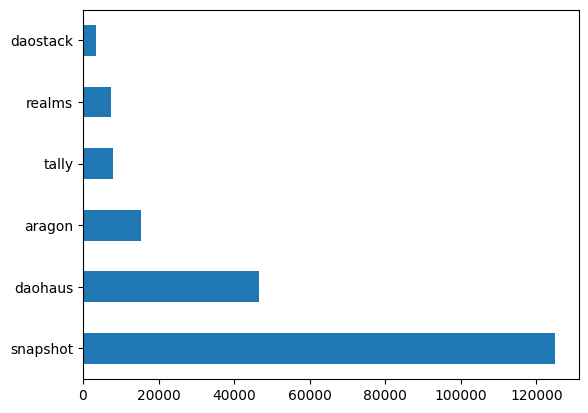

In [40]:
# show hist by platform
import pyarrow.parquet as pq

with pq.ParquetFile('parquets/proposals.parquet') as pf:
    df = pf.read().to_pandas()
df.platform.value_counts().plot.barh()

In [28]:
# now for votes
import glob

# get all the csv files in the DATA/deployments folder
votes = glob.glob('/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/*_votes.csv')
assert len(votes) == 5
# THIS IS MISSING SNAPSHOT bc its in a parquet, not a csv
votes

['/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/realms_votes.csv',
 '/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daostack_votes.csv',
 '/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/tally_votes.csv',
 '/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/aragon_votes.csv',
 '/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daohaus_votes.csv']

In [3]:
import glob

snapshot_votes = glob.glob('/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/snapshot_*.parquet')[0]
snapshot_votes

'/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/snapshot_votes.parquet'

In [28]:
# get snapshot_votes schema
import pyarrow.parquet as pq

with pq.ParquetFile(snapshot_votes) as pf:
    # num_rows = pf.metadata.num_rows
    # num_columns = len(pf.metadata.schema.names)
    schema = pf.metadata.schema
# convert pyarrow._parquet.ParquetSchema to  pyarrow.lib.Schema
schema = schema.to_arrow_schema()
# make weight a double instead of an int
schema = schema.set(7, pa.field('weight', pa.float64()))
# set date precision to millisecond like timestamp[ms]
schema = schema.set(5, pa.field('date', pa.timestamp('ms')))
print(schema)

platform: string
platform_deployment_id: string
proposal_id: string
vote_id: string
voter: string
date: timestamp[ms]
choice: string
weight: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1194


In [43]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime


def votes_csv_to_parquet(filenames: iter, out_filename: str) -> None:
    rows_count = 0
    chunksize = 1000000  # this is the number of lines
    t1 = datetime.now()
    table_exists = False
    pqwriter = None
    # if filename exists, raise error
    if glob.glob(out_filename):
        raise FileExistsError(f'{out_filename} already exists')
    for file in filenames:
        print(file)
        for i, df in enumerate(pd.read_csv(file, chunksize=chunksize)):
            print(df.shape)
            # if dates are all null, set to datetime
            if df.date.isna().all():
                # for empty strings, make them not a time
                df['date'] = pd.to_datetime(df['date'], unit='s')
                # print the number of dates that are not a time
                print(df.date.isna().sum(), 'dates are not a time', file)
            # if choice is not a string, make it a string
            df['choice'] = df['choice'].astype(str)
            table = pa.Table.from_pandas(df)
            # set date precision to millisecond
            table = table.set_column(5, 'date', table.column(5).cast(pa.timestamp('ms')))
            # if weight is not a double, cast it to a double
            if table.column(7).type != pa.float64():
                table = table.set_column(7, 'weight', table.column(7).cast(pa.float64()))
                print('weight was not a double', file)
            # describe table weight
            # if file doesn't exist, create it
            if not table_exists:
                # create a parquet write object giving it an output file
                pqwriter = pq.ParquetWriter(out_filename, schema)
                table_exists = True
            pqwriter.write_table(table)
            rows_count += len(df)
            print('.')
    # TODO: add in snapshot...
    if pqwriter:
        pqwriter.close()
    t2 = datetime.now()
    total = t2 - t1
    print(f'took {total} to pandas concat')
    print(f'wrote {rows_count} rows to {out_filename}')

votes_csv_to_parquet(votes, 'parquets/votes_without_snapshot.parquet')

/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/realms_votes.csv
(22552, 8)
22552 dates are not a time /users/personal/Downloads/DATA_onedrive_2023-07-25/votes/realms_votes.csv
.
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daostack_votes.csv
(12328, 8)
weight was not a double /users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daostack_votes.csv
.
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/tally_votes.csv


/opt/homebrew/lib/python3.11/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


(583597, 8)
weight was not a double /users/personal/Downloads/DATA_onedrive_2023-07-25/votes/tally_votes.csv
.
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/aragon_votes.csv
(26176, 8)
weight was not a double /users/personal/Downloads/DATA_onedrive_2023-07-25/votes/aragon_votes.csv
.
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daohaus_votes.csv
(49454, 8)
.
took 0:00:03.656349 to pandas concat
wrote 694107 rows to parquets/votes_without_snapshot.parquet


In [29]:
# count the number of lines in each of the files in votes without reading them to memory
lines_count = 0
for file in votes:
    print(file)
    with open(file) as f:
        count = sum(1 for line in f)
        print(count)
    lines_count += count
print(lines_count, 'lines in all votes files')
lines_count = lines_count - len(votes)  # subtract the header lines
print(lines_count, 'lines in all votes files without headers')

/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/realms_votes.csv
22553
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daostack_votes.csv
12329
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/tally_votes.csv
583598
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/aragon_votes.csv
26177
/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/daohaus_votes.csv
49455
694112 lines in all votes files
694107 lines in all votes files without headers


In [45]:
assert lines_count == 694_107

In [17]:
files_to_concat = ['parquets/votes_without_snapshot.parquet', snapshot_votes]
files_to_concat

['parquets/votes_without_snapshot.parquet',
 '/users/personal/Downloads/DATA_onedrive_2023-07-25/votes/snapshot_votes.parquet']

In [23]:
import pyarrow as pa
import pyarrow.parquet as pq
import os
from datetime import datetime

def concat_parquets(filenames: iter) -> None:
    t1 = datetime.now()
    pqwriter = None
    for filename in filenames:
        parquet_file = pq.ParquetFile(filename)
        for i, batch_table in enumerate(parquet_file.iter_batches()):
            table = pa.Table.from_batches([batch_table])
            # cast the date column to timestamp[us]
            table = table.set_column(5, 'date', table.column(5).cast(pa.timestamp('us')))
            # if weight is not a double, cast it to a double
            # we want to use Decimal128Type, cast to that
            if table.column(7).type != pa.decimal256(62, 8):
                table = table.set_column(7, 'weight', table.column(7).cast(pa.decimal256(62, 8)))
                # print('weight was not a decimal128', filename)

            if os.path.isfile('parquets/votes.parquet') == False:
                # create a parquet write object giving it an output file
                pqwriter = pq.ParquetWriter('parquets/votes.parquet', table.schema)
            pqwriter.write_table(table)
    if pqwriter:
        pqwriter.close()
    t2 = datetime.now()
    total = t2 - t1
    print(f'took {total} to concat')

concat_parquets(files_to_concat)

took 0:00:18.833714 to concat


In [25]:
# how many lines in snapshot_votes
import pyarrow.parquet as pq

with pq.ParquetFile(snapshot_votes) as pf:
    num_rows = pf.metadata.num_rows
    print(num_rows)

21173881


In [32]:
expected_size = num_rows + lines_count
expected_size

21867988

In [34]:
# open the votes.parquet file and check the number of rows
import pyarrow.parquet as pq

with pq.ParquetFile('parquets/votes.parquet') as pf:
    num_rows = pf.metadata.num_rows
assert num_rows == expected_size
# wooo!!